In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
from tensorflow import keras
from tensorflow.keras import layers

##GETTING OUR DATA READY

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/HAR_MODIFIED.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
import os
for dirpath, dirnames, filenames in os.walk("/content/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 15 directories and 0 images in '/content/train'.
There are 0 directories and 680 images in '/content/train/sitting'.
There are 0 directories and 680 images in '/content/train/running'.
There are 0 directories and 680 images in '/content/train/listening_to_music'.
There are 0 directories and 680 images in '/content/train/eating'.
There are 0 directories and 680 images in '/content/train/drinking'.
There are 0 directories and 680 images in '/content/train/fighting'.
There are 0 directories and 680 images in '/content/train/clapping'.
There are 0 directories and 680 images in '/content/train/sleeping'.
There are 0 directories and 680 images in '/content/train/cycling'.
There are 0 directories and 680 images in '/content/train/using_laptop'.
There are 0 directories and 680 images in '/content/train/texting'.
There are 0 directories and 680 images in '/content/train/calling'.
There are 0 directories and 680 images in '/content/train/laughing'.
There are 0 directories and 680 image

In [5]:
for dirpath, dirnames, filenames in os.walk("/content/test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 15 directories and 0 images in '/content/test'.
There are 0 directories and 84 images in '/content/test/sitting'.
There are 0 directories and 84 images in '/content/test/running'.
There are 0 directories and 84 images in '/content/test/listening_to_music'.
There are 0 directories and 84 images in '/content/test/eating'.
There are 0 directories and 84 images in '/content/test/drinking'.
There are 0 directories and 84 images in '/content/test/fighting'.
There are 0 directories and 84 images in '/content/test/clapping'.
There are 0 directories and 84 images in '/content/test/sleeping'.
There are 0 directories and 84 images in '/content/test/cycling'.
There are 0 directories and 84 images in '/content/test/using_laptop'.
There are 0 directories and 84 images in '/content/test/texting'.
There are 0 directories and 84 images in '/content/test/calling'.
There are 0 directories and 84 images in '/content/test/laughing'.
There are 0 directories and 84 images in '/content/test/dancing'

In [6]:
for dirpath, dirnames, filenames in os.walk("/content/val"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 15 directories and 0 images in '/content/val'.
There are 0 directories and 75 images in '/content/val/sitting'.
There are 0 directories and 75 images in '/content/val/running'.
There are 0 directories and 75 images in '/content/val/listening_to_music'.
There are 0 directories and 75 images in '/content/val/eating'.
There are 0 directories and 75 images in '/content/val/drinking'.
There are 0 directories and 75 images in '/content/val/fighting'.
There are 0 directories and 75 images in '/content/val/clapping'.
There are 0 directories and 75 images in '/content/val/sleeping'.
There are 0 directories and 75 images in '/content/val/cycling'.
There are 0 directories and 75 images in '/content/val/using_laptop'.
There are 0 directories and 75 images in '/content/val/texting'.
There are 0 directories and 75 images in '/content/val/calling'.
There are 0 directories and 75 images in '/content/val/laughing'.
There are 0 directories and 75 images in '/content/val/dancing'.
There are 0 d

In [7]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(samplewise_center = True,zca_whitening = True)
test_datagen = ImageDataGenerator(samplewise_center = True,zca_whitening = True)
validation_datagen = ImageDataGenerator(samplewise_center = True,zca_whitening = True)

train_data = train_datagen.flow_from_directory(train_dir,batch_size = 32,class_mode = "categorical",target_size = (224,224),seed=42,shuffle = True)
test_data = test_datagen.flow_from_directory(test_dir,batch_size = 32,class_mode = "categorical",target_size = (224,224),seed=42,shuffle = False)
validation_data  = validation_datagen.flow_from_directory(val_dir,batch_size = 32,class_mode = "categorical",target_size = (224,224),seed=42,shuffle = False)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 10200 images belonging to 15 classes.
Found 1260 images belonging to 15 classes.
Found 1125 images belonging to 15 classes.


In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

test_data_true = image_dataset_from_directory(test_dir,label_mode = "categorical",batch_size = 32,image_size = (224,224),
                                          shuffle = False,seed = 42)

Found 1260 files belonging to 15 classes.


In [10]:
print(train_data)
print(test_data)
print(validation_data)

In [11]:
labels = test_data_true.class_names
print(len(labels))
print(labels)


15
['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']


##FEATURE EXTRACTOR RESNET152V2 MODEL

In [12]:
base_model = tf.keras.applications.ResNet152V2(include_top = False)
base_model.trainable = False

234561536/234545216 [==============================] - 3s 0us/step


In [13]:
data_aug = keras.Sequential([
      layers.experimental.preprocessing.RandomHeight(0.2),
      layers.experimental.preprocessing.RandomWidth(0.2),
      layers.experimental.preprocessing.RandomRotation(0.2),
      layers.experimental.preprocessing.Rescaling(1/255.)
])

In [14]:
inputs = layers.Input(shape = (224,224,3))
x = data_aug(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32,activation = "relu",kernel_initializer= tf.keras.initializers.HeNormal())(x)
x = layers.Dense(15)(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)

model_res = keras.Model(inputs,outputs)

In [15]:
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                             

In [16]:
for layer_num,layer in enumerate(model_res.layers):
  print(layer_num,layer.name,layer.trainable)

0 input_2 True
1 sequential True
2 resnet152v2 False
3 global_average_pooling2d True
4 dense True
5 dense_1 True
6 activation True


In [17]:
model_res.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [18]:
checkpoint_path = "HAR_Resnet/Checkpoint.ckpt"
checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,monitor = "val_accuracy",save_best_only=True,
                                                 save_weights_only = True, verbose = 1)

In [19]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import plot_loss_curves,create_tensorboard_callback

--2022-07-28 13:54:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-28 13:55:00 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",patience = 15,verbose = 1,
                                              min_delta = 0.00001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy",patience = 10,verbose = 1,
                                                 min_lr = 1e-8)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/2))

In [21]:
history_1 =  model_res.fit(train_data,epochs  = 20,steps_per_epoch = len(train_data),
                        validation_data = validation_data,validation_steps= len(validation_data),
                         callbacks = [create_tensorboard_callback(dir_name = "HAR_TRANSFER_LEARNING_FINAL",experiment_name = "RESNET"),early_stop,reduce_lr,
                                      checkpoints])

Saving TensorBoard log files to: HAR_TRANSFER_LEARNING_FINAL/RESNET/20220728-135518


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
319/319 [==============================] - ETA: 0s - loss: 1.8392 - accuracy: 0.4103
Epoch 1: val_accuracy improved from -inf to 0.57511, saving model to HAR_Resnet/Checkpoint.ckpt
319/319 [==============================] - 76s 174ms/step - loss: 1.8392 - accuracy: 0.4103 - val_loss: 1.3590 - val_accuracy: 0.5751 - lr: 0.0010
Epoch 2/20
319/319 [==============================] - ETA: 0s - loss: 1.4246 - accuracy: 0.5409
Epoch 2: val_accuracy improved from 0.57511 to 0.62044, saving model to HAR_Resnet/Checkpoint.ckpt
319/319 [==============================] - 49s 154ms/step - loss: 1.4246 - accuracy: 0.5409 - val_loss: 1.2650 - val_accuracy: 0.6204 - lr: 0.0010
Epoch 3/20
319/319 [==============================] - ETA: 0s - loss: 1.3345 - accuracy: 0.5717
Epoch 3: val_accuracy improved from 0.62044 to 0.62400, saving model to HAR_Resnet/Checkpoint.ckpt
319/319 [==============================] - 47s 148ms/step - loss: 1.3345 - accuracy: 0.5717 - val_loss: 1.1933 - val_accurac

In [22]:
print("Validation Accuracy = ",model_res.evaluate(validation_data))
print("Testing Accuracy is = ",model_res.evaluate(test_data))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


36/36 [==============================] - 4s 98ms/step - loss: 1.0363 - accuracy: 0.6782
Validation Accuracy =  [1.0362685918807983, 0.6782222390174866]
40/40 [==============================] - 4s 99ms/step - loss: 0.9317 - accuracy: 0.7079
Testing Accuracy is =  [0.9317252039909363, 0.7079365253448486]


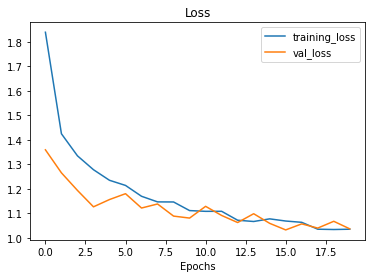

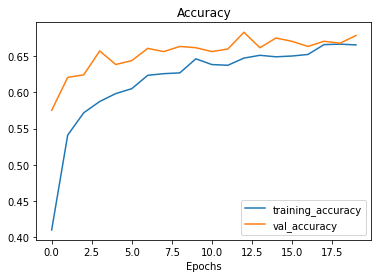

In [23]:
plot_loss_curves(history_1)

In [24]:
for layer_num,layer in enumerate(base_model.layers):
  print(layer_num,layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

##FINE TUNED RESNET152V2(40 LAYERS)

In [25]:
base_model.trainable = True
for layer in base_model.layers[:-40]:
  layer.trainable = False

In [26]:
for layer_num,layer in enumerate(base_model.layers):
  print(layer_num,layer.name,layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [27]:
model_res.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                  metrics = ["accuracy"])

In [28]:
history_2 = model_res.fit(train_data,epochs = 50,steps_per_epoch=len(train_data),initial_epoch = history_1.epoch[-1],
                          validation_data  = validation_data,validation_steps = len(validation_data),
                          callbacks = [create_tensorboard_callback(dir_name = "HAR_TRANSFER_LEARNING_FINAL",experiment_name = "RESNET_FINE_TUNED"),
                                       early_stop,reduce_lr])

Saving TensorBoard log files to: HAR_TRANSFER_LEARNING_FINAL/RESNET_FINE_TUNED/20220728-141457


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 20/50
319/319 [==============================] - 67s 173ms/step - loss: 1.2227 - accuracy: 0.6041 - val_loss: 1.0378 - val_accuracy: 0.6693 - lr: 1.0000e-05
Epoch 21/50
319/319 [==============================] - 45s 142ms/step - loss: 1.0771 - accuracy: 0.6573 - val_loss: 0.9919 - val_accuracy: 0.7013 - lr: 1.0000e-05
Epoch 22/50
319/319 [==============================] - 46s 143ms/step - loss: 1.0104 - accuracy: 0.6765 - val_loss: 0.9449 - val_accuracy: 0.7156 - lr: 1.0000e-05
Epoch 23/50
319/319 [==============================] - 46s 144ms/step - loss: 0.9482 - accuracy: 0.6994 - val_loss: 0.9284 - val_accuracy: 0.7129 - lr: 1.0000e-05
Epoch 24/50
319/319 [==============================] - 45s 142ms/step - loss: 0.9252 - accuracy: 0.7022 - val_loss: 0.8980 - val_accuracy: 0.7262 - lr: 1.0000e-05
Epoch 25/50
319/319 [==============================] - 45s 140ms/step - loss: 0.8660 - accuracy: 0.7244 - val_loss: 0.8829 - val_accuracy: 0.7289 - lr: 1.0000e-05
Epoch 26/50
319/319 [=

In [29]:
print("Validation Accuracy = ",model_res.evaluate(validation_data))
print("Testing Accuracy is = ",model_res.evaluate(test_data))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


36/36 [==============================] - 4s 99ms/step - loss: 0.6847 - accuracy: 0.8142
Validation Accuracy =  [0.6846758723258972, 0.8142222166061401]
40/40 [==============================] - 4s 99ms/step - loss: 0.5041 - accuracy: 0.8476
Testing Accuracy is =  [0.5040616989135742, 0.8476190567016602]


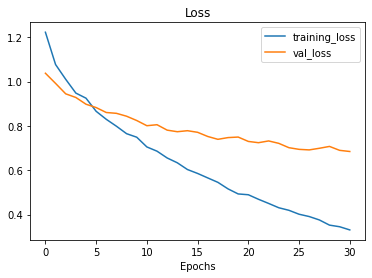

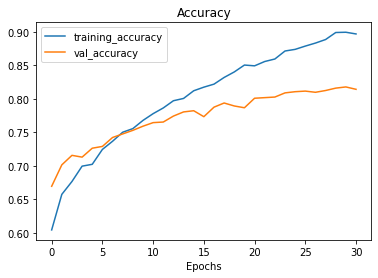

In [30]:
plot_loss_curves(history_2)

##MODEL EVALUATION

In [31]:
pred_probs = model_res.predict(test_data)
print(len(pred_probs))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1260


In [32]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 3,  9, 11, 13,  0,  0,  0,  0,  0, 14])

In [34]:
y_true = []
for img,label in test_data_true.unbatch():
  y_true.append(label.numpy().argmax())

y_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

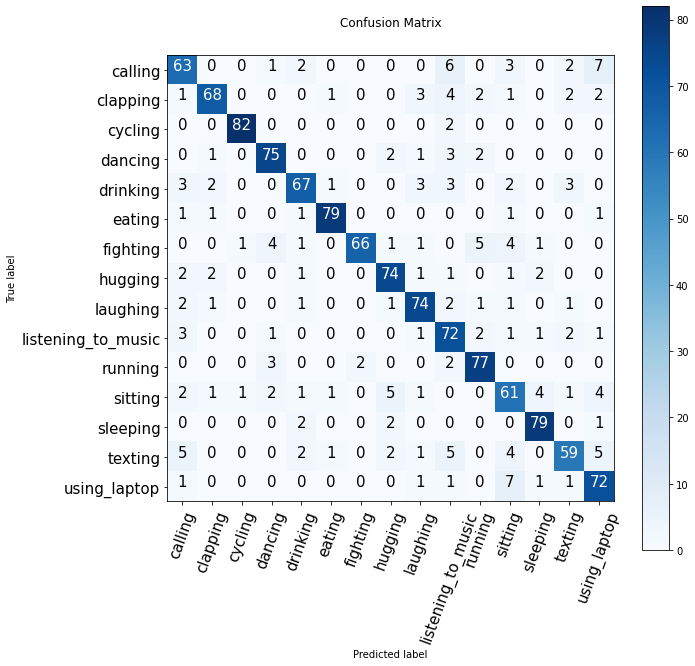

In [36]:
make_confusion_matrix(y_true,pred_classes,classes = labels)

In [37]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true, pred_classes)
sklearn_accuracy

0.8476190476190476

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75        84
           1       0.89      0.81      0.85        84
           2       0.98      0.98      0.98        84
           3       0.87      0.89      0.88        84
           4       0.86      0.80      0.83        84
           5       0.95      0.94      0.95        84
           6       0.97      0.79      0.87        84
           7       0.85      0.88      0.87        84
           8       0.85      0.88      0.87        84
           9       0.71      0.86      0.78        84
          10       0.87      0.92      0.89        84
          11       0.71      0.73      0.72        84
          12       0.90      0.94      0.92        84
          13       0.83      0.70      0.76        84
          14       0.77      0.86      0.81        84

    accuracy                           0.85      1260
   macro avg       0.85      0.85      0.85      1260
weighted avg       0.85   

In [39]:
classification_report_dict = classification_report(y_true, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.7544910179640718,
  'precision': 0.7590361445783133,
  'recall': 0.75,
  'support': 84},
 '1': {'f1-score': 0.8500000000000001,
  'precision': 0.8947368421052632,
  'recall': 0.8095238095238095,
  'support': 84},
 '10': {'f1-score': 0.8901734104046243,
  'precision': 0.8651685393258427,
  'recall': 0.9166666666666666,
  'support': 84},
 '11': {'f1-score': 0.7176470588235294,
  'precision': 0.7093023255813954,
  'recall': 0.7261904761904762,
  'support': 84},
 '12': {'f1-score': 0.9186046511627907,
  'precision': 0.8977272727272727,
  'recall': 0.9404761904761905,
  'support': 84},
 '13': {'f1-score': 0.7612903225806451,
  'precision': 0.8309859154929577,
  'recall': 0.7023809523809523,
  'support': 84},
 '14': {'f1-score': 0.8135593220338982,
  'precision': 0.7741935483870968,
  'recall': 0.8571428571428571,
  'support': 84},
 '2': {'f1-score': 0.9761904761904762,
  'precision': 0.9761904761904762,
  'recall': 0.9761904761904762,
  'support': 84},
 '3': {'f1-score'

In [40]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    class_f1_scores[labels[int(k)]] = v["f1-score"]

class_f1_scores

{'calling': 0.7544910179640718,
 'clapping': 0.8500000000000001,
 'cycling': 0.9761904761904762,
 'dancing': 0.8823529411764706,
 'drinking': 0.8271604938271606,
 'eating': 0.9461077844311376,
 'fighting': 0.8684210526315789,
 'hugging': 0.8654970760233917,
 'laughing': 0.8654970760233917,
 'listening_to_music': 0.7783783783783783,
 'running': 0.8901734104046243,
 'sitting': 0.7176470588235294,
 'sleeping': 0.9186046511627907,
 'texting': 0.7612903225806451,
 'using_laptop': 0.8135593220338982}

In [41]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
2,cycling,0.976190
5,eating,0.946108
12,sleeping,0.918605
10,running,0.890173
3,dancing,0.882353
6,fighting,0.868421
7,hugging,0.865497
8,laughing,0.865497
1,clapping,0.850000
4,drinking,0.827160


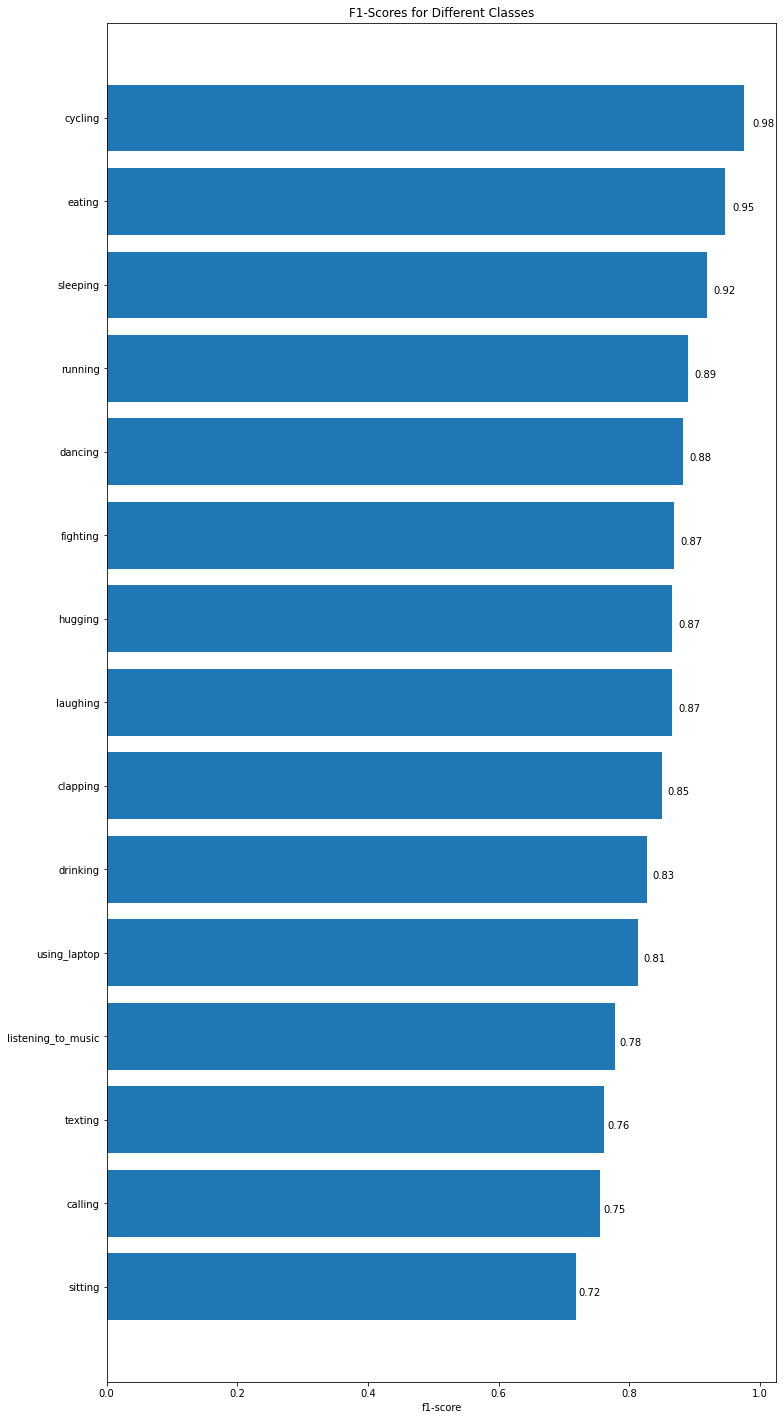

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

##TENSORBOARD VISUALIZATION

In [ ]:
!tensorboard dev upload --logdir ./HAR_TRANSFER_LEARNING_FINAL// \
  --name "HAR_RESNET152V2" \
  --description "Comparing feature extractor and fine tuning model of ResNet152V2 on HAR Still Image Classfication" \
  --one_shot

TENSORBOARD LINK:

https://tensorboard.dev/experiment/mOTa2MKqRHaSlAgtdHBQlA/



---

                                                         CONCLUSION


---

